# Activation Patching by entire attention layers only - record next token prediction probability

In [1]:
from nnsight import LanguageModel
import einops
import torch
torch.set_grad_enabled(False)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
llm = LanguageModel("meta-llama/Llama-3.2-1B", device_map="auto", torch_dtype=torch.bfloat16)

In [3]:
llm

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [4]:
N_LAYERS = llm.model.config.num_hidden_layers
N_HEADS = llm.model.config.num_attention_heads
hidden_size = llm.model.layers[0].self_attn.q_proj.weight.shape[0]
HEAD_SIZE = hidden_size // N_HEADS

In [18]:
prompt = """The capital of France is Paris.
The capital of France is Berlin.
Now I will give the correct answer.
The capital of France is"""

corrupted_prompt = """The capital of France is Paris.
The capital of France is Berlin.
Now I will give the incorrect answer.
The capital of France is"""

prompts = [prompt, corrupted_prompt]

In [6]:
# Define the answers to these prompts, formatted as (correct, incorrect)
answers = [
    (" Paris", " Berlin"),
    (" Berlin", " Paris")
]

In [7]:
# Tokenize clean and corrupted prompts
clean_tokens = llm.tokenizer(prompts[0], return_tensors="pt")["input_ids"]
corrupted_tokens = llm.tokenizer(prompts[1], return_tensors="pt")["input_ids"]

answer_token_indices = [
    [llm.tokenizer(answers[i][j])["input_ids"][1] for j in range(2)]
    for i in range(len(answers))
]
print("answer_token_indices=", answer_token_indices)

answer_token_indices= [[12366, 20437], [20437, 12366]]


In [19]:
patching_results = []

with llm.trace() as tracer:
    # Clean run, grab clean activations for each attention layer
    with tracer.invoke(prompts[0]) as invoker:
        clean_tokens = invoker.inputs[0][0]["input_ids"][0]
        z_l = {}
        for layer in range(N_LAYERS):
            z_l[layer] = llm.model.layers[layer].self_attn.output.save()
        
        # Get logits from lm_head
        clean_logits = llm.lm_head.output
        clean_logit_difference = (clean_logits[0, -1, answer_token_indices[0][0]] - clean_logits[0, -1, answer_token_indices[0][1]]).save()

    # Corrupter run, grab the corrupted logits for later comparison    
    with tracer.invoke(prompts[1]) as invoker:
        corrupted_tokens = invoker.inputs[0][0]["input_ids"][0]
        corrupted_logits = llm.lm_head.output
        corrupted_logit_difference = (corrupted_logits[0, -1, answer_token_indices[0][0]] - corrupted_logits[0, -1, answer_token_indices[0][1]]).save()

    # Start with the activation patching: iterate through all the layers
    for layer in range(N_LAYERS):
        patch_results = []
        with tracer.invoke(prompts[1]) as invoker:
            llm.model.layers[layer].self_attn.output = z_l[layer]

            patched_logits = llm.lm_head.output
            patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()

            patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
            patch_results.append(patched_result.item().save())
            patching_results.append(patch_results)

    
patching_results = {
    "clean_run_logit_difference": clean_logit_difference,
    "corrupted_run_logit_difference": corrupted_logit_difference,
    "patching_results": patching_results
}
patching_results

{'clean_run_logit_difference': tensor(1.3750, device='mps:0', dtype=torch.bfloat16),
 'corrupted_run_logit_difference': tensor(0.8750, device='mps:0', dtype=torch.bfloat16),
 'patching_results': [[0.0],
  [0.25],
  [-0.75],
  [0.5],
  [0.5],
  [0.5],
  [-0.25],
  [0.5],
  [0.5],
  [-0.25],
  [-1.0],
  [0.5],
  [-0.25],
  [0.25],
  [0.5],
  [0.0]]}

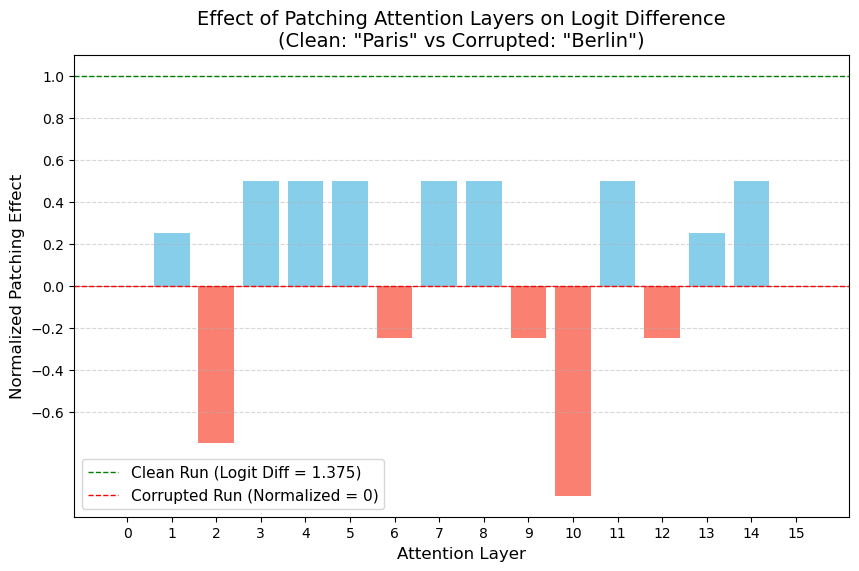

In [21]:
# Extract layer-wise patching results (flatten the nested list)
layer_effects = [float(result[0].value) for result in patching_results["patching_results"]]  # Ensure plain flo.item().item()
layers = np.arange(len(layer_effects))  # Layer indices: 0 to 15

# Convert tensors to Python scalars explicitly
clean_diff = float(patching_results["clean_run_logit_difference"].item())  # Extract scalar
corrupted_diff = float(patching_results["corrupted_run_logit_difference"].item())  # Extract scalar

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(layers, layer_effects, color=np.where(np.array(layer_effects) >= 0, 'skyblue', 'salmon'))
plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)  # Zero line for reference
plt.axhline(1, color='green', linestyle='--', linewidth=1, label=f'Clean Run (Logit Diff = {clean_diff:.3f})')
plt.axhline(0, color='red', linestyle='--', linewidth=1, label=f'Corrupted Run (Normalized = 0)')

# Customize
plt.xlabel('Attention Layer', fontsize=12)
plt.ylabel('Normalized Patching Effect', fontsize=12)
plt.title('Effect of Patching Attention Layers on Logit Difference\n(Clean: "Paris" vs Corrupted: "Berlin")', fontsize=14)
plt.xticks(layers, fontsize=10)
plt.yticks(np.arange(-0.6, 1.2, 0.2), fontsize=10)
plt.legend(fontsize=11)

# Add grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate key bars (e.g., max positive, max negative)
max_pos_idx = np.argmax(layer_effects)
max_neg_idx = np.argmin(layer_effects)
for bar in bars:
    height = bar.get_height()
    if bar.get_x() in [max_pos_idx, max_neg_idx]:
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', 
                 ha='center', va='bottom' if height >= 0 else 'top', fontsize=10, color='black')

# Tight layout and save
# plt.tight_layout()
# plt.savefig('patching_effects.pdf', format='pdf', dpi=300)  # Save as high-quality PDF for paper
plt.show()